In [2]:
import pandas as pd 
import numpy as np 
from collections import Counter

In [21]:
class Node:
    
    '''
    Class for creating the Nodes for a decision Tree
    '''
    def __init__(self, Y:list, X:pd.DataFrame, min_samples_split=None, max_depth=None, depth=None, node_type=None, rule=None):
        
        # Saving the Data to the Node
        self.Y = Y
        self.X = X
        
        # Saving the hyper parameters
        self.min_samples_split = min_samples_split if min_samples_split else 20
        self.max_depth = max_depth if max_depth else 5
        
        # Default the current depth
        self.depth = depth if depth else 0
        
        # Extracting all the features
        self.features = list(self.X.columns)
        
        # Type of Node
        self.node_type = node_type if node_type else 'root'
        
        # Rule for splitting
        self.rule = rule if rule else ""
        
        # Calculating the counts of Y in the node
        self.counts = Counter(Y)
        
        # Getting the GINI impurity based on the Y distribution
        self.gini_impurity = self.get_GINI()
        
        # Sorting the counts and saving the final prediction of the node
        counts_sorted = list(sorted(self.counts.items(), key=lambda item: item[-1]))
        
        # Getting the last item
        yhat = None
        if len(counts_sorted):
            yhat = counts_sorted[-1][0]
            
        # Saving to object attribute. This node will predict the class with the most frequent class
        self.yhat = yhat
        
        # Saving the number of observations in the node
        self.n = len(Y)
        
        # Initiating the left and right nodes as empty nodes
        self.left = None
        self.right = None
        
        # Default values for splits
        self.best_feature = None
        self.best_value = None
        
        
    @staticmethod
    def GINI_impurity(y1_count:int, y2_count:int) -> float:
        """
        Given the observations of a binary class claculate the GINI impurity
        """
        
        # Ensuring the correct types
        if y1_count is None:
            y1_count = 0
            
        if y2_count is None:
            y2_count = 0
            
        # Getting the total observations
        n = y1_count + y2_count
        
        # if n is 0 the we return the lowest possible gini impurity
        if n==0:
            return 0.0
        
        # Getting the probability to see each of the class
        p1 = y1_count / n
        p2 = y2_count / n
        
        # Calculating GINI
        gini = 1 - (p1**2 + p2**2)
        
        # Returning the gini impurity
        return gini
    
    
    @staticmethod
    def ma(x: np.array, window:int) -> np.array:
        """
        Calculates the moving average of the given list
        """
        return np.convolve(x, np.ones(window), 'valid') / window
    
    
    def get_GINI(self):
        """
        Function to calculate the GINI impurity of a node
        """
        # Getting the 0 and 1 counts
        y1_count, y2_count = self.counts.get(0,0), self.counts.get(0,1)
        
        # Getting the GINI impurity
        return self.GINI_impurity(y1_count,y2_count)
        
    
    def best_split(self) -> tuple:
        """
        Given the X features and Y targets calculates the best split
        for a decision tree
        """
        # Creating a dataset for spliting
        df = self.X.copy()
        df['Y'] = self.Y
        
        # Getting the GINI impurity for the base input
        GINI_base = self.get_GINI()
        
        # Finding which split yields the best GINI gain
        max_gain = 0
        
        # Default best feature and split
        best_feature = None
        best_value = None
        
        for feature in self.features:
            
            # Dropping missing values
            Xdf = df.dropna().sort_values(feature)
            
            # Sorting the values and getting the rolling average
            xmeans = self.ma(Xdf[feature].unique(), 2)
            
            for value in xmeans:
                
                # Splitting the dataset
                left_counts = Counter(Xdf[Xdf[feature]<value]['Y'])
                right_counts = Counter(Xdf[Xdf[feature]>=value]['Y'])
                
                # Getting the Y distribution from the dicts
                y0_left, y1_left, y0_right, y1_right = left_counts.get(0,0), left_counts.get(1,0), right_counts.get(0,0), right_counts.get(1,0)
                
                # Getting the left and right gini impurities
                gini_left = self.GINI_impurity(y0_left,y1_left)
                gini_right = self.GINI_impurity(y0_right,y1_right)
                
                # Getting the obs count from the left and right data splits
                n_left = y0_left + y1_left
                n_right = y0_right + y1_right
                
                # Calculating the weights for each of the nodes
                w_left = n_left / (n_left + n_right)
                w_right = n_right / (n_left + n_right)
                
                # Calculating the weighted GINI impurity
                wGINI = w_left * gini_left + w_right * gini_right
                
                # Calculating the GINI gain
                GINIgain = GINI_base - wGINI
                
                # Checking if this is the best split so far
                if GINIgain > max_gain:
                    
                    best_feature = feature
                    best_value = value
                    
                    # Setting the best gain to current one
                    max_gain = GINIgain
                    
        return (best_feature,best_value)
    
    
    def grow_tree(self):
        """
        Recursive method to create the decision tree
        """
        
        # Making a df from the data 
        df = self.X.copy()
        df['Y'] = self.Y
        
        # If there is GINI to be gained, we split further 
        if (self.depth < self.max_depth) and (self.n >= self.min_samples_split):
            
            # Getting the best split
            best_feature, best_value = self.best_split()
            
            if best_feature is not None:
                
                # Saving the best split to the current node
                self.best_feature = best_feature
                self.best_value = best_value
                
                # Getting the left and right noodes
                left_df, right_df = df[df[best_feature]<=best_value].copy(), df[df[best_feature]>best_value].copy()
                
                # Creating the left and right Nodes
                left = Node(left_df['Y'].values.tolist(),
                           left_df[self.features],
                           depth=self.depth + 1,
                           max_depth=self.max_depth,
                           min_samples_split=self.min_samples_split,
                           node_type='left_node',
                           rule=f"{best_feature} <= {round(best_value,3)}")
                
                self.left = left
                self.left.grow_tree()
                
                right = Node(right_df['Y'].values.tolist(),
                            right_df[self.features],
                            max_depth=self.max_depth,
                            min_samples_split=self.min_samples_split,
                            node_type='right_node',
                            rule=f"{best_feature} > {round(best_value,3)}")
                
                self.right = right
                self.right.grow_tree()
     
    
    def print_info(self, width=4):
        """
        Method to print the information about the tree
        """
        # Defining the number of spaces
        const = int(self.depth * width ** 1.5)
        spaces = "-" * const
        
        
        if self.node_type == "root":
            
            print("Root")
            
        else:
            
            print(f"|{spaces} Split rule: {self.rule}")
            
        print(f"{' ' * const} | GINI impurity of the node: {round(self.gini_impurity, 2)}")
        print(f"{' ' * const} | Class distribution in the node: {dict(self.counts)}")
        print(f"{' ' * const} | Predicted class: {self.yhat}")
        
        
    def print_tree(self):
        """
        Prints the whole tree from the current node to the bottom
        """
        self.print_info()
        
        if self.left is not None:
            self.left.print_tree()
            
        if self.right is not None:
            self.right.print_tree()
         
        
    def predict(self, X:pd.DataFrame):
        """
        Batch prediction Method
        """
        predictions = []
        
        for _, x in X.iterrows():
            
            values = {}
            
            for feature in self.features:
                
                values.update({feature: x[feature]})
                
            predictions.append(self.predict_obs(values))
            
            
        return predictions
    
    
    def predict_obs(self, values:dict) -> int:
        """
        Method to predict the class given a set of features
        """
        cur_node = self
        
        while cur_node.depth < cur_node.max_depth:
            
            # Traversing the nodes all the way to the bottom
            best_feature = cur_node.best_feature
            best_value = cur_node.best_value
            
            if cur_node.n < cur_node.min_samples_split:
                break
                
            if (values.get(best_feature) < best_value):
                if self.left is not None:
                    cur_node = cur_node.left
                    
            else:
                if self.right is not None:
                    cur_node = cur_node.right
                    
        return cur_node.yhat                

In [22]:
d = pd.read_csv("https://raw.githubusercontent.com/Eligijus112/decision-tree-python/main/data/classification/train.csv")

In [23]:
# Dropping missing values
dtree = d[['Survived', 'Age', 'Fare']].dropna().copy()

In [24]:
# Defining the X and Y matrices
Y = dtree['Survived'].values
X = dtree[['Age', 'Fare']]

In [25]:
# Saving the feature list 
features = list(X.columns)

In [26]:
# we define the dictionary of hyperparameters.
hp = {
 'max_depth': 3,
 'min_samples_split': 50
}

In [27]:
# we initiate the root node
root = Node(Y, X, **hp)

In [28]:
# The main tree building function is the grow_tree() function.
root.grow_tree()

In [29]:
# To view the results, we can invoke the print_tree() function
root.print_tree()

Root
 | GINI impurity of the node: 0.5
 | Class distribution in the node: {0: 424, 1: 290}
 | Predicted class: 0
|-------- Split rule: Fare <= 52.277
         | GINI impurity of the node: 0.5
         | Class distribution in the node: {0: 389, 1: 195}
         | Predicted class: 0
|---------------- Split rule: Fare <= 10.481
                 | GINI impurity of the node: 0.5
                 | Class distribution in the node: {0: 192, 1: 47}
                 | Predicted class: 0
|------------------------ Split rule: Age <= 32.5
                         | GINI impurity of the node: 0.5
                         | Class distribution in the node: {0: 134, 1: 43}
                         | Predicted class: 0
| Split rule: Age > 32.5
 | GINI impurity of the node: 0.5
 | Class distribution in the node: {0: 58, 1: 4}
 | Predicted class: 0
|-------- Split rule: Fare <= 9.544
         | GINI impurity of the node: 0.5
         | Class distribution in the node: {0: 57, 1: 3}
         | Predicted cla

In [41]:
# Predicting 
Xsubset = X.copy()
Xsubset['yhat'] = root.predict(Xsubset)
print(Xsubset)

      Age     Fare  yhat
0    22.0   7.2500     0
1    38.0  71.2833     1
2    26.0   7.9250     0
3    35.0  53.1000     1
4    35.0   8.0500     0
..    ...      ...   ...
885  39.0  29.1250     0
886  27.0  13.0000     0
887  19.0  30.0000     1
889  26.0  30.0000     1
890  32.0   7.7500     0

[714 rows x 3 columns]


In [43]:
pred = root.predict(Xsubset)

In [45]:
from sklearn.metrics import accuracy_score

In [46]:
accuracy_score(Y,pred)

0.726890756302521

## Using Scikit Learn

In [33]:
from sklearn.model_selection import train_test_split,GridSearchCV

In [34]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.33,random_state=10)

In [35]:
from sklearn.tree import DecisionTreeClassifier
model = DecisionTreeClassifier()

In [36]:
model.fit(X_train,y_train)

DecisionTreeClassifier()

In [37]:
model.score(X_train,y_train)

0.9853556485355649

[Text(0.5572406690882291, 0.9782608695652174, 'X[1] <= 52.277\ngini = 0.479\nsamples = 478\nvalue = [288, 190]'),
 Text(0.22313579174563067, 0.9347826086956522, 'X[0] <= 5.5\ngini = 0.437\nsamples = 387\nvalue = [262, 125]'),
 Text(0.02021478205938092, 0.8913043478260869, 'X[1] <= 26.95\ngini = 0.346\nsamples = 27\nvalue = [6, 21]'),
 Text(0.013476521372920615, 0.8478260869565217, 'gini = 0.0\nsamples = 16\nvalue = [0, 16]'),
 Text(0.02695304274584123, 0.8478260869565217, 'X[1] <= 30.256\ngini = 0.496\nsamples = 11\nvalue = [6, 5]'),
 Text(0.013476521372920615, 0.8043478260869565, 'X[0] <= 1.415\ngini = 0.32\nsamples = 5\nvalue = [4, 1]'),
 Text(0.006738260686460307, 0.7608695652173914, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]'),
 Text(0.02021478205938092, 0.7608695652173914, 'gini = 0.0\nsamples = 4\nvalue = [4, 0]'),
 Text(0.04042956411876184, 0.8043478260869565, 'X[1] <= 39.344\ngini = 0.444\nsamples = 6\nvalue = [2, 4]'),
 Text(0.03369130343230154, 0.7608695652173914, 'gini = 0.0\n

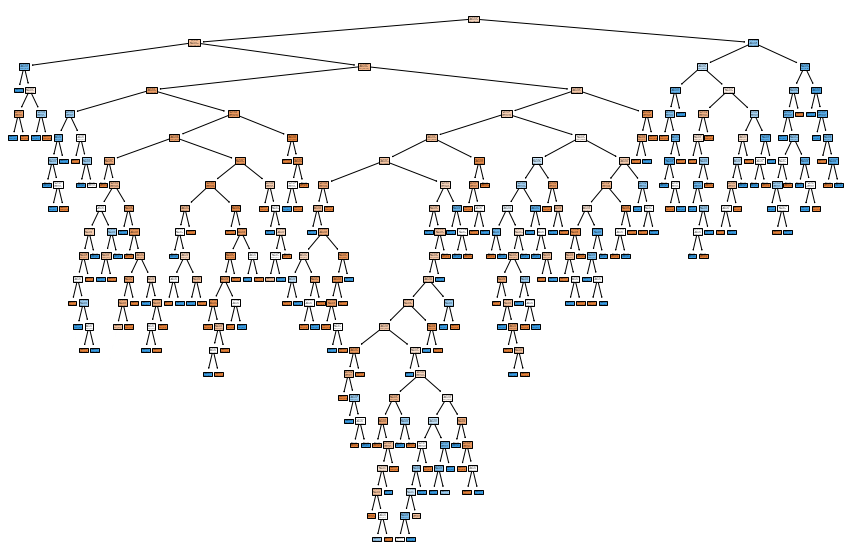

In [38]:
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))
tree.plot_tree(model,filled=True)

In [39]:
y_predict=model.predict(X_test)

In [49]:
from sklearn.metrics import accuracy_score

In [50]:
accuracy_score(y_test,y_predict)

0.5932203389830508

In [51]:
grid_param = {
    'max_depth': range(2,10,1),
    'min_samples_split': range(2,10,1),
}

In [52]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=model,param_grid=grid_param,cv=5)

In [53]:
grid_search.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(2, 10),
                         'min_samples_split': range(2, 10)})

In [54]:
grid_search.best_params_

{'max_depth': 5, 'min_samples_split': 2}

In [60]:
model_with_best_param = DecisionTreeClassifier(max_depth=3,min_samples_split=50)

In [61]:
model_with_best_param.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=3, min_samples_split=50)

In [62]:
y_predict2=model_with_best_param.predict(X_test)

In [63]:
accuracy_score(y_test,y_predict2)

0.673728813559322

[Text(0.5, 0.875, 'X[1] <= 52.277\ngini = 0.479\nsamples = 478\nvalue = [288, 190]'),
 Text(0.25, 0.625, 'X[0] <= 5.5\ngini = 0.437\nsamples = 387\nvalue = [262, 125]'),
 Text(0.125, 0.375, 'gini = 0.346\nsamples = 27\nvalue = [6, 21]'),
 Text(0.375, 0.375, 'X[1] <= 8.673\ngini = 0.411\nsamples = 360\nvalue = [256, 104]'),
 Text(0.25, 0.125, 'gini = 0.306\nsamples = 143\nvalue = [116, 27]'),
 Text(0.5, 0.125, 'gini = 0.458\nsamples = 217\nvalue = [140, 77]'),
 Text(0.75, 0.625, 'X[1] <= 79.425\ngini = 0.408\nsamples = 91\nvalue = [26, 65]'),
 Text(0.625, 0.375, 'gini = 0.48\nsamples = 45\nvalue = [18, 27]'),
 Text(0.875, 0.375, 'gini = 0.287\nsamples = 46\nvalue = [8, 38]')]

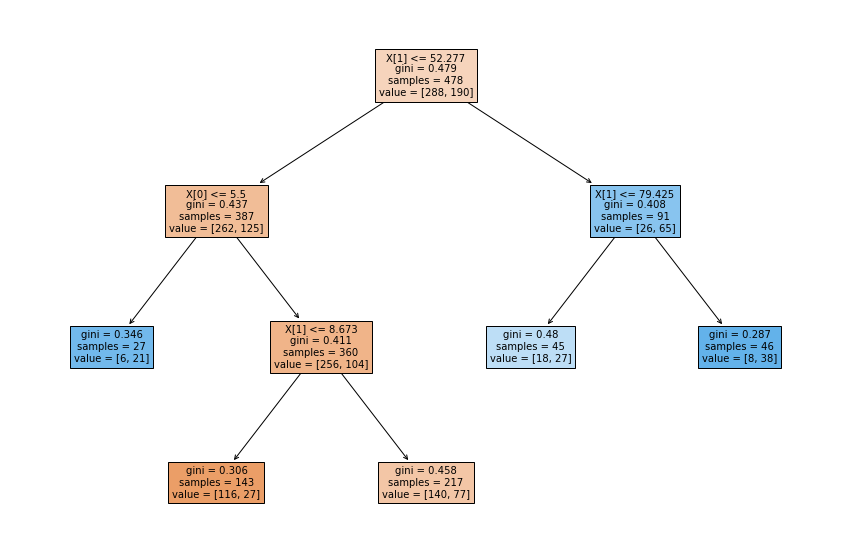

In [64]:
from sklearn import tree
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(15,10))
tree.plot_tree(model_with_best_param,filled=True,fontsize=10)